<br>

## 시계열 데이터 준비 <br><br>

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume) 데이터 존재 <br>
우리는 Close만 사용 (종가 : 하루의 장이 마감하였을 때의 가격)

<br>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [48]:
# 판다스 Dataframe 으로 csv 데이터의 'Close' 열 읽어오기

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_samsung = df['Close']

ts_samsung.head(10)

Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
2020-03-02    55000.0
2020-03-03    55400.0
2020-03-04    57400.0
2020-03-05    57800.0
2020-03-06    56500.0
Name: Close, dtype: float64

<br>

### 데이터 확인

<br>

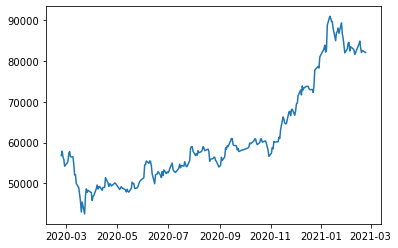

In [50]:
# 'Close' 칼럼 데이터 확인

plt.plot(ts_samsung)

<br>

## 분석 전 단계 : 전처리 <br><br>

- 결측치 처리

<br>

In [52]:
# 결측치 처리

# 판다스 interpolate(보간) 메서드로 NAN 결측데이터 매꾸기
ts_samsung = ts_samsung.interpolate(method='time')

# Time Series 에서 결측치(NAN)가 있는 부분만 Series 로 출력하여 처리 결과 확인
ts_samsung[ts_samsung.isna()]

Series([], Name: Close, dtype: float64)

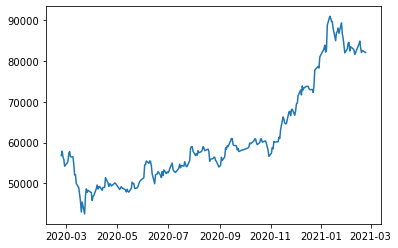

In [53]:
# 결측치(NAN) 처리 후 그래프 다시 확인

plt.plot(ts_samsung)

<br>

## Non-stationary 데이터 Stationary 하게 데이터 변환 <br><br>

1. 로그 데이터로 변환 <br>
( 데이터가 시간의 추이에 따라 분산이 점점 커지는 경우 ) <br>
: 원본 데이터에 log 를 취해줍니다. <br><br>

2. 추세(Trend) 제거 <br>
( 이동평균의 시차 범위에 따른 stationarity 차이 존재 ) <br>
: 원본 데이터에서 특정 범위만큼의 이동평균 결과를 제거해 줍니다. <br><br>

3. 계절성(Seasonality) 제거 <br>
( 차분 정도(shift step) 에 따른 stationarity 차이 존재 ) <br>
: 원본 데이터에서 특정 스텝 만큼 쉬프트한 데이터를 제거해 줍니다. <br><br>

4. Residual 데이터 staionarity 확인 <br>
: 위의 세 단계 거친 결과가 Residual 입니다. <br>
( Orihinal = Trend + Seasonality + Residual )

<br>

<br>

## 시계열 안정성(Stationarity) 여부 분석 <br><br>

- 정성적 그래프 분석 <br><br>

- 정량적 ADF-Test (Augmented Dicky-Fuller Test) 분석

<br>

<br>

### 시계열 안정성 여부 분석 : 정성적 분석 <br><br>

시계열 안정성 여부의 정성적 분석을 위해 그래프 플롯

<br>

In [57]:
# 이동평균 구하는 함수 작성
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

<br>

### 시계열 안정성 여부 분석 : 정량적 분석 <br><br>

시계열 안정성 여부의 정량적 분석을 위해 Augmented Dicky-Fuller Test 함수를 작성하여 시행

<br>

In [31]:
# statsmodels 패키지 adfuller 메서드로 함수 작성

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):

    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

<br>

### 1. 로그데이터로 변환

<br>

In [54]:
# 로그 변환

# 넘파이 log 함수 적용
ts_samsung_log = np.log(ts_samsung)

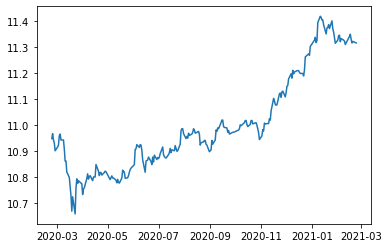

In [55]:
# 로그 변환된 시계열 데이터 그래프 확인

plt.plot(ts_samsung_log)

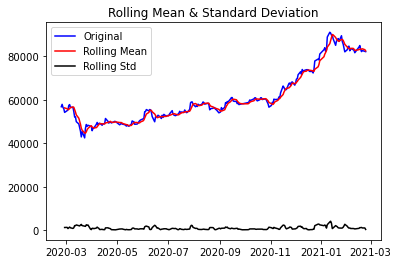

In [59]:
# 정성적 그래프 분석
# 원본 시계열 데이터

plot_rolling_statistics(ts_samsung, window=5)

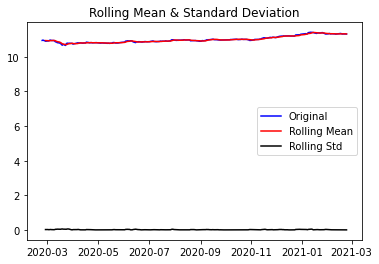

In [58]:
# 정성적 그래프 분석
# 로그 변환된 시계열 데이터

plot_rolling_statistics(ts_samsung_log, window=5)

In [67]:
# 정량적 Augmented Dicky-Fuller Test 분석
# 원본 시계열 데이터

augmented_dickey_fuller_test(ts_samsung)

Results of Dickey-Fuller Test:
Test Statistic                   0.091659
p-value                          0.965487
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [60]:
# 정량적 Augmented Dicky-Fuller Test 분석
# 로그 변환된 시계열 데이터

augmented_dickey_fuller_test(ts_samsung_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.095163
p-value                          0.949918
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


<br>

#### 정량적 분석 결과 <br><br>

원본 시계열 데이터와 로그 변환된 시계열 데이터 모두 <br>
p-value 가 0.94 정도로, 두 시계열 데이터 모두 안정적인 시계열 데이터라고 볼 수 없습니다.

<br>

<br>

### 2. 3. 4. 시계열 분해 <br><br>

statsmodels 모듈의 seasonal_decompose 메서드 활용 <br>
trend, seasonal, residual 데이터로 시계열 분해

<br>

In [65]:
# 시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_samsung_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

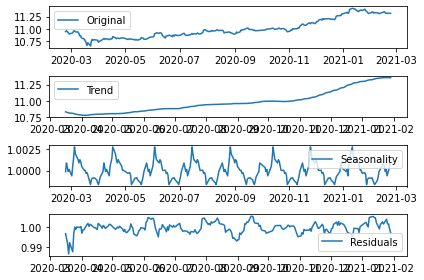

In [64]:
# 시계열 분해 데이터 정성적 그래프 분석

# 시계열 분해 결과 plot
plt.subplot(411)
plt.plot(ts_samsung_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [66]:
# 시계열 분해 데이터 중 Residual 데이터 정량적 분석 (안정성 확인)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.901085e+00
p-value                        2.777052e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


<br>

### 정상성(Stationarity) 확인 <br><br>

Non-stationary 한 데이터들을 여러 방법으로 정제한 결과, <br>
로그변환을 거치고 시계열 분해를 통해 얻어진 Residual 데이터는 압도적으로 낮은 p-value를 보여 줍니다. <br><br>

이 정도면 '예측 가능한 수준의 안정적인 시계열 데이터'가 얻어졌다고 볼 수 있습니다.

<br>

<br>

## 학습, 테스트 데이터셋 생성

<br>

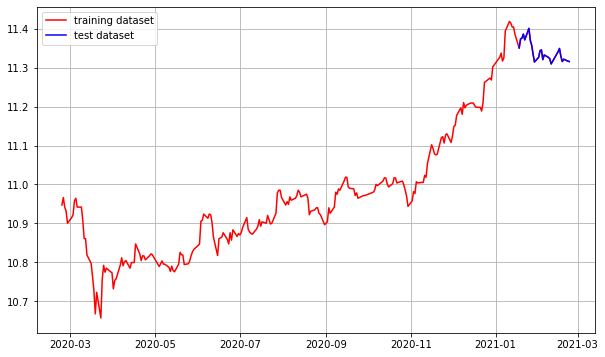

In [68]:
# 학습, 테스트 데이터셋 9:1 로 생성

train_data, test_data = ts_samsung_log[:int(len(ts_samsung_log)*0.9)], ts_samsung_log[int(len(ts_samsung_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_samsung_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

<br>

## 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

<br>

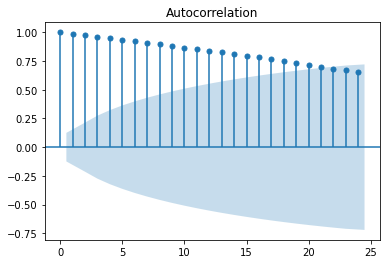

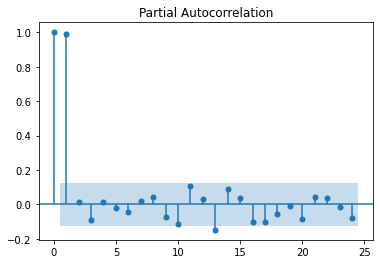

In [71]:

# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_samsung_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_samsung_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.604459e+01
p-value                        5.863660e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.231318e+00
p-value                        1.991223e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


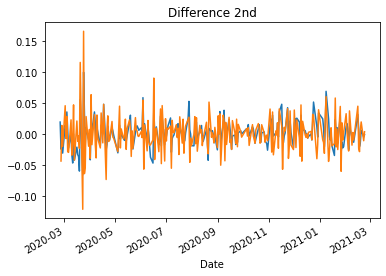

In [72]:
# 1차 차분 구하기
diff_1 = ts_samsung_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<br>

## ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

<br>

In [73]:
# ARIMA 모델 구성 후 훈련(fit)
# p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 우선적으로 고려

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1069.052
Time:                        23:54:30   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

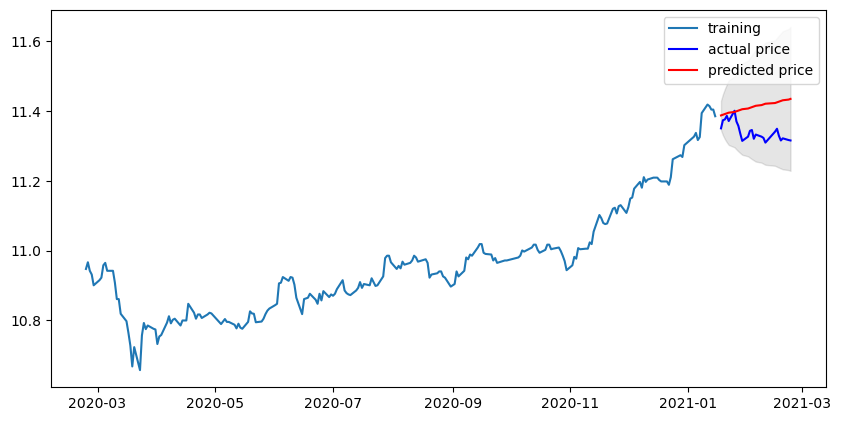

In [74]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [75]:
# 최종 예측 모델 정확도 측정 (MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46306474.799547836
MAE:  6036.034938311395
RMSE:  6804.88609747054
MAPE: 7.25%


<br>

# 다른 주식 종목 예측 <br><br>

위 과정을 다른 주식 종목에 적용

<br>